In [57]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from glob import glob

In [58]:
COLOR_TRAIN_DIR = "data/train_color"
BLACK_TRAIN_DIR = "data/train_black"
COLOR_TEST_DIR = "data/test_color"
BLACK_TEST_DIR = "data/test_black2"
IMG_SIZE = 16 #images are 400x400 ---- Make them smaller to use less memory but keep accuracy
BATCH_SIZE = 25 # hyperparameter we need to optimize
EPOCHS = 5
NUMBER_OF_IMAGES = 5000
DEVICE = torch.device("cpu") #running on my macbook without a gpu ---- CAN ADD GPU SUPPPORT FOR OTHER DEVICES

## Step 1 is to create a class that can hold our loaded datasets, as well as process the images in our dataset for the model

In [59]:
class ColorizationDataset(Dataset):
    # Built in double underscore python method to be the classe's constructor
    def __init__(self, colorPaths, grayscalePaths, imageSize):
        # This will define all images to class variables that are passed in the paths. i.e. "data/train_color" for self.colorpaths
        self.colorPaths = sorted(glob(os.path.join(colorPaths, '*.jpg')))[:NUMBER_OF_IMAGES]
        self.grayscalePaths = sorted(glob(os.path.join(grayscalePaths, '*.jpg')))[:NUMBER_OF_IMAGES]
        self.imageSize = imageSize

    # Built in double underscore python method to get length of data that our class instance holds
    def __len__(self):
        return len(self.grayscalePaths)

    # Function to process grayscale training photos into L color space channel and return tensor
    def processGrayscale(self, grayscaleImagePath):
        grayscaleImage = cv2.imread(grayscaleImagePath, cv2.IMREAD_GRAYSCALE)
        grayscaleImage = cv2.resize(grayscaleImage, (self.imageSize, self.imageSize))
        # Since IMREAD_GRAYSCALE is already in L channel, we can just normalize grayscaleimage to be within -1 to 1
        L = (grayscaleImage.astype(np.float32) - 128) / 128
        L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
        return L

    # Function to process color training photos into a and b channels into a single stacked tensor
    def processColor(self, colorImagePath):
        colorImage = cv2.imread(colorImagePath)
        colorImage = cv2.resize(colorImage, (self.imageSize, self.imageSize))

        # Defines LAB color space by using Opencv functions to take a colored image and put in into Lab
        labColorSpace = cv2.cvtColor(colorImage, cv2.COLOR_BGR2Lab)

        # Gets the chrominance of a and b channels by making all values within the range [-1,1] (Commonly used in neural networks)
        L, a, b = cv2.split(labColorSpace)

        # Normalize a and b values to be within -1 to 1
        L = (L.astype(np.float32) - 128) / 128
        a = (a.astype(np.float32) - 128) / 128
        b = (b.astype(np.float32) - 128) / 128
        # Using stack to speed-up performance by joining a and b channels stacked on the 0 axis (All of a stacked on all of b)
        lab = torch.tensor(np.stack([L,a,b], axis=0), dtype=torch.float32)

        return lab

    # Built in double underscore python method to get the index of the item in our class instance.
    def __getitem__(self, idx):
        grayscaleImagePath = self.grayscalePaths[idx]
        colorImagePath = self.colorPaths[idx]
        processedGrayscale = self.processGrayscale(grayscaleImagePath)
        processedColor = self.processColor(colorImagePath)
        return processedColor, processedGrayscale



        

In [60]:
class ColorizationModelNeuralNetwork(nn.Module):
    # Class construction using same built in python double underscore method
    def __init__(self):
        super(ColorizationModelNeuralNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(), # USING THE RELU ACTIVATION FUNCTION LIKE WE SAW IN CLASS
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=(3,3), padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [61]:
# This will put our images into a class dataset so we can load and process the images before training the model
train_dataset = ColorizationDataset(COLOR_TRAIN_DIR, BLACK_TRAIN_DIR, IMG_SIZE)
test_dataset = ColorizationDataset(COLOR_TEST_DIR, BLACK_TEST_DIR, IMG_SIZE)

# Loads the data correctly in a certain batch size to help with the EPOCH's in our training process.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Now we want to initialize the model, the mean squared error loss criterion, and the optimizer for our model

In [62]:
colorizerModel = ColorizationModelNeuralNetwork().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(colorizerModel.parameters(), lr=0.0001)

## Now Load Our Image Dataset we chose and Train the Model

In [63]:
for epoch in range(EPOCHS):
    colorizerModel.train()
    running_loss = 0.0
    for color_lab_space, grayScale_L_channel in train_loader:
        color_lab_space, grayScale_L_channel = color_lab_space.to(DEVICE), grayScale_L_channel.to(DEVICE)
        optimizer.zero_grad()
        grayscale_lab_prediction = colorizerModel(grayScale_L_channel)
        loss = criterion(grayscale_lab_prediction, color_lab_space)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/5, Loss: 0.0242
Epoch 2/5, Loss: 0.0111
Epoch 3/5, Loss: 0.0100
Epoch 4/5, Loss: 0.0093
Epoch 5/5, Loss: 0.0091


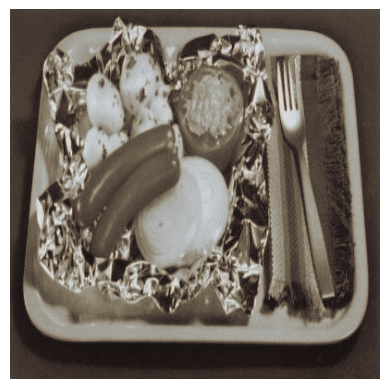

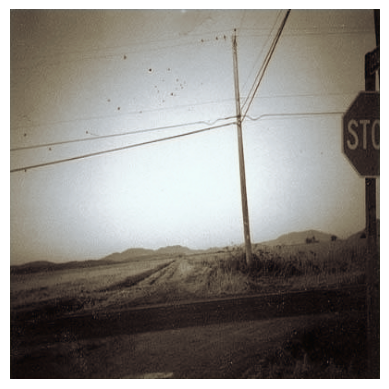

In [64]:
def colorizeImage(model, imagePath):
    L_image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    L_image = (L_image.astype(np.float32) - 128) / 128
    L_tensor = torch.tensor(L_image, dtype=torch.float32).unsqueeze(0)
    L_tensor = L_tensor.to(DEVICE)

    with torch.no_grad():
        lab_prediction = model(L_tensor).cpu()

    lab_prediction = lab_prediction.squeeze().numpy()
    # Un-regularizes the values that were between [-1,1]
    l = lab_prediction[0].astype(np.float32) * 128 + 128
    a = lab_prediction[1].astype(np.float32) * 128 + 128
    b = lab_prediction[2].astype(np.float32) * 128 + 128
    
    #L = ((L_image * 128) + 128) 
    
    # uint8 is so that the values will be 2^8 bit so range will be within rgb values
    colorized_lab = cv2.merge([l.astype(np.uint8), a.astype(np.uint8), b.astype(np.uint8)])

    colorized_bgr = cv2.cvtColor(colorized_lab, cv2.COLOR_LAB2BGR)

    plt.imshow(cv2.cvtColor(colorized_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def colorizeTestSet(model, imageSetPath):
    for image in os.listdir(imageSetPath):
        if image.endswith('.jpg'):
            grayscalePath = os.path.join(imageSetPath, image)
            colorizeImage(model, grayscalePath)

colorizeTestSet(colorizerModel, BLACK_TEST_DIR)